# Part III: PyTorch RNN (40 points)

# 3.1 Task 1

Implement the RNN without using torch.nn.RNN and torch.nn.LSTM. Follow the skeleton provided in train.py
(for the training) and vanilla rnn.py (to define the model). For the forward pass you will need to use a for loop
to step through time and apply the recurrence equations that define the network behaviour. For the backward pass
you can rely on Pytorch’s automatic differentiation and use the RMSProp optimizer for tuning the weights.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn

class VanillaRNN(nn.Module):
    def __init__(self, input_length, input_dim, hidden_dim, output_dim, batch_size):
        # h_t = tanh(W_hx x_t + W_hh h_{t-1} + b_h)
        # o_t = W_ph h_t + b_o
        super().__init__()
        self.input_length = input_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.W_hx = nn.Linear(input_dim, hidden_dim)   # x_t -> h_t
        self.W_hh = nn.Linear(hidden_dim, hidden_dim)  # h_{t-1} -> h_t
        self.W_ph = nn.Linear(hidden_dim, output_dim)  # h_t -> o_t
        self.tanh = nn.Tanh()


    def forward(self, x):
        if x.dim() == 2:
            B, T = x.size()
            x = x.unsqueeze(-1).float()  # [B, T, 1]
        else:
            B, T, D = x.size()
            x = x.float()
        h = torch.zeros(1, B, self.hidden_dim, device=x.device)  # [1, B, H]

        # 逐时间步递归
        for t in range(T):
            xt = x[:, t, :]                           # [B, input_dim]
            # W_hx(xt) 返回 [B, H]; h.squeeze(0) 是 [B, H]
            h_t = self.tanh(self.W_hx(xt) + self.W_hh(h.squeeze(0)))  # [B, H]
            h = h_t.unsqueeze(0)  # [1, B, H]

        # 输出最后一步的预测
        out = self.W_ph(h.squeeze(0))  # [B, output_dim]
        return out

# 3.2 Task 2


Given the RNN implemented in Task 1 and a palindrome of length T , the network should be able to predict the
T -th digit given the preceeding T − 1 ones. Now, as studied in the lecture this morning, RNN have a limited
memory. So we expect the prediction accuracy of the RNN become lower as we challenge it with longer and longer
palindromes. Using a jupyter notebook create a plot that shows accuracy versus palindrome length. You should be
able to obtain close to perfect accuracy with T = 5 and the default parameters provided in the python files.

In [2]:
from dataset import PalindromeDataset
import matplotlib.pyplot as plt

ds = PalindromeDataset(seq_length=10)   # 你要的长度
print('Dataset length:', len(ds))

for i in range(5):
    seq, last = ds[i]
    print(f'sample {i}: input={seq}  target={int(last)}')

Dataset length: 1000000
sample 0: input=[2. 2. 3. 4. 4. 4. 4. 3. 2.]  target=2
sample 1: input=[1. 7. 1. 6. 9. 9. 6. 1. 7.]  target=1
sample 2: input=[1. 2. 1. 9. 7. 7. 9. 1. 2.]  target=1
sample 3: input=[8. 4. 4. 1. 7. 7. 1. 4. 4.]  target=8
sample 4: input=[0. 4. 2. 3. 2. 2. 3. 2. 4.]  target=0


In [3]:

import argparse, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataset import PalindromeDataset          # 你的代码 
def train(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VanillaRNN(input_length=config.input_length,
                       input_dim=config.input_dim, 
                       hidden_dim=config.num_hidden,
                       output_dim=config.num_classes,
                       batch_size=config.batch_size).to(device)
    dataset = PalindromeDataset(config.input_length)
    loader  = DataLoader(dataset, batch_size=config.batch_size,
                         shuffle=True, num_workers=0)

    # 3. 损失 & 优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=config.learning_rate)

    # 4. 记录
    losses, accs = [], []

    # 5. 主循环
    step_iter = tqdm(range(config.train_steps), desc='Steps')
    for step, (seq, label) in zip(step_iter, loader):
        seq   = seq[:, :config.input_length].to(device)        
        label = label.to(device)
        # 前向
        logits = model(seq)            # [B, 10]
        loss   = criterion(logits, label)
        # 反向
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), config.max_norm)
        optimizer.step()
        # 记录
        acc = (logits.argmax(1) == label).float().mean().item()
        losses.append(loss.item())
        accs.append(acc)
        if (step + 1) % config.print_every == 0:
            step_iter.set_postfix(loss=f'{loss.item():.4f}', acc=f'{acc:.4f}')

        if step + 1 >= config.train_steps:
            break

    print('Done training.')
    return model, {'loss': losses, 'acc': accs}

In [ ]:
class Config:
    def __init__(self,input_length=5,input_dim=1, num_classes=10,
                 num_hidden=128, batch_size=128, learning_rate=0.001,
                 train_steps=10000, max_norm=10.0, print_every=200):
        self.input_length = input_length
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.num_hidden  = num_hidden
        self.batch_size  = batch_size
        self.learning_rate = learning_rate
        self.train_steps = train_steps
        self.max_norm    = max_norm
        self.print_every = print_every



Steps: 100%|█████████▉| 999/1000 [00:03<00:00, 250.61it/s, acc=1.0000, loss=0.0019]



Done training.


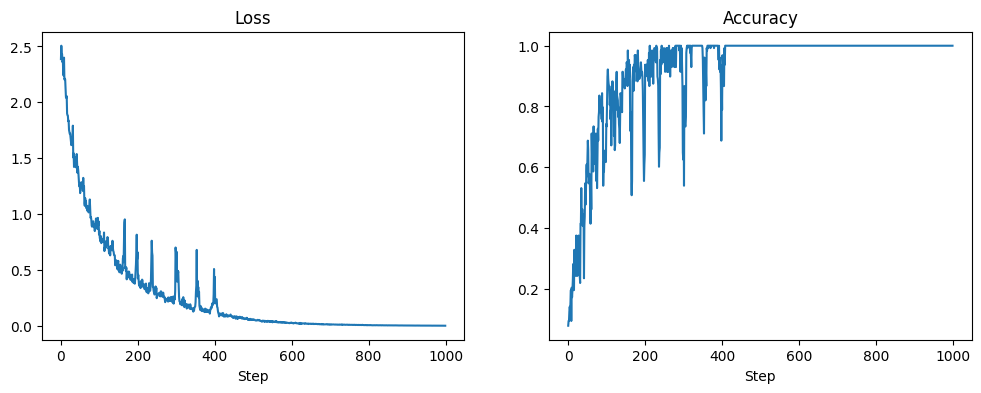

In [13]:
import matplotlib.pyplot as plt

model, hist = train(Config())

# 绘制训练曲线
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(hist['loss']); ax1.set_title('Loss'); ax1.set_xlabel('Step')
ax2.plot(hist['acc']); ax2.set_title('Accuracy'); ax2.set_xlabel('Step')
plt.show()

# 3.2 Task 2
 Given the RNN implemented in Task 1 and a palindrome of length T, the network should be able to predict the
 T-th digit given the preceeding T − 1 ones. Now, as studied in the lecture this morning, RNN have a limited
 memory. So we expect the prediction accuracy of the RNN become lower as we challenge it with longer and longer
 palindromes. Using a jupyter notebook create a plot that shows accuracy versus palindrome length. You should be
 able to obtain close to perfect accuracy with T = 5 and the default parameters provided in the python files.


Training for length 5 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:12<00:00, 111.40it/s, acc=1.0000, loss=0.0003]



Done training.
Length 5: test accuracy = 1.0000

Training for length 6 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:12<00:00, 110.28it/s, acc=1.0000, loss=0.0001]



Done training.
Length 6: test accuracy = 1.0000

Training for length 7 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:14<00:00, 97.32it/s, acc=1.0000, loss=0.0012]



Done training.
Length 7: test accuracy = 1.0000

Training for length 8 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:15<00:00, 92.93it/s, acc=1.0000, loss=0.0005]



Done training.
Length 8: test accuracy = 1.0000

Training for length 9 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:16<00:00, 83.24it/s, acc=1.0000, loss=0.0045]



Done training.
Length 9: test accuracy = 1.0000

Training for length 10 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:17<00:00, 80.11it/s, acc=0.1172, loss=2.3154]



Done training.
Length 10: test accuracy = 0.1006

Training for length 11 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:19<00:00, 73.27it/s, acc=0.1016, loss=2.3223]



Done training.
Length 11: test accuracy = 0.1074

Training for length 12 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:19<00:00, 69.98it/s, acc=0.1094, loss=2.3047]



Done training.
Length 12: test accuracy = 0.1084

Training for length 13 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:21<00:00, 64.70it/s, acc=0.0859, loss=2.3169]



Done training.
Length 13: test accuracy = 0.1035

Training for length 14 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:22<00:00, 62.74it/s, acc=0.0781, loss=2.3161]



Done training.
Length 14: test accuracy = 0.0928

Training for length 15 (steps=1400)...


Steps: 100%|█████████▉| 1399/1400 [00:23<00:00, 58.47it/s, acc=0.0781, loss=2.3094]



Done training.
Length 15: test accuracy = 0.0928


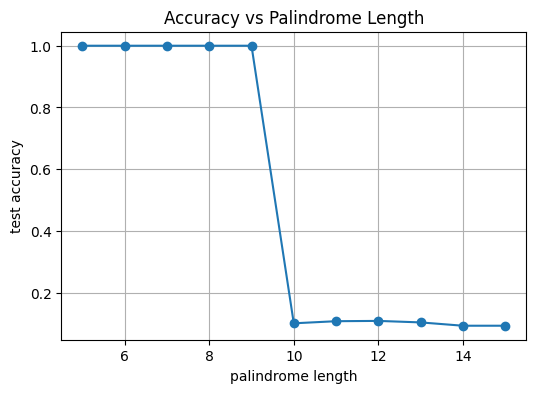

In [6]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def evaluate_model(model, seq_length, num_samples=1024, batch_size=128):
    device = next(model.parameters()).device
    ds = PalindromeDataset(seq_length)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for seq, label in loader:
            seq = seq[:, :model.input_length].to(device)
            label = label.to(device)
            logits = model(seq)
            preds = logits.argmax(1)
            correct += (preds == label).sum().item()
            total += label.size(0)
            if total >= num_samples:
                break
    return correct / total if total > 0 else 0.0

# 对几个不同的回文长度做比较
lengths = [5,6,7,8,9,10,11,12,13,14,15]
results = {}
for L in lengths:
    cfg = Config(input_length=L, train_steps=1400, batch_size=128, num_hidden=128, learning_rate=0.001, print_every=200)
    print(f'\nTraining for length {L} (steps={cfg.train_steps})...')
    model, hist = train(cfg)
    acc = evaluate_model(model, L, num_samples=1024, batch_size=cfg.batch_size)
    results[L] = acc
    print(f'Length {L}: test accuracy = {acc:.4f}')

# 绘制长度 vs 准确率
plt.figure(figsize=(6,4))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel('palindrome length')
plt.ylabel('test accuracy')
plt.title('Accuracy vs Palindrome Length')
plt.grid(True)
plt.show()